In [1]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM

from gptomics import gptneo, transformers, composition as comp

# Automatically rounding outputs to 4 digits
np.set_printoptions(precision=4)

In [2]:
model = transformers.load_model("EleutherAI/gpt-neo-125M")

In [3]:
type(model)

transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM

In [4]:
OVins = [comp.removemean(gptneo.OV(model, 0, i)) for i in range(model.config.num_heads)]
QKs = [gptneo.QK(model, 1, i) for i in range(model.config.num_heads)]
OVouts = [gptneo.OV(model, 1, i) for i in range(model.config.num_heads)]

In [5]:
Qcomps = np.empty((12, 12), dtype=np.float32)

for i in range(model.config.num_heads):
    for j in range(model.config.num_heads):
        Qcomps[i, j] = comp.Qcomposition(QKs[j], OVins[i], center=False)

In [6]:
Kcomps = np.empty((12, 12), dtype=np.float32)

for i in range(model.config.num_heads):
    for j in range(model.config.num_heads):
        Kcomps[i, j] = comp.Kcomposition(QKs[j], OVins[i], center=False)

In [7]:
Vcomps = np.empty((12, 12), dtype=np.float32)

for i in range(model.config.num_heads):
    for j in range(model.config.num_heads):
        Vcomps[i, j] = comp.Vcomposition(OVins[i], OVouts[j], center=False)

In [8]:
import matplotlib
from matplotlib import pyplot as plt

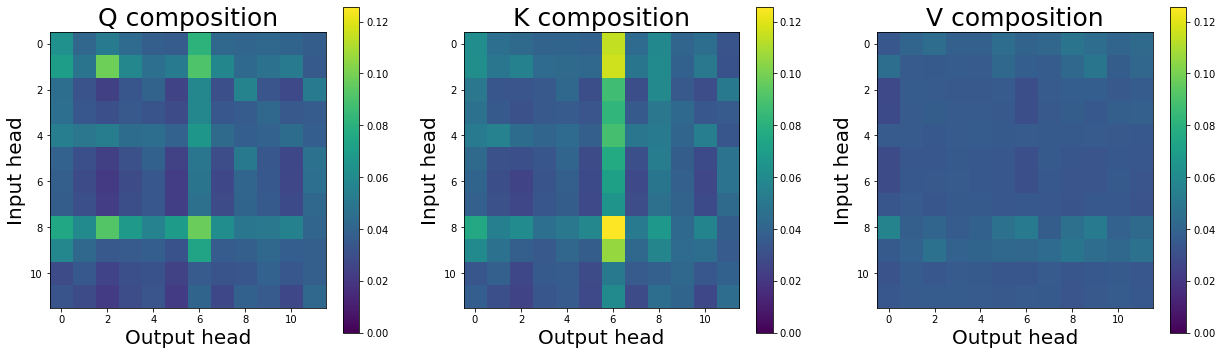

In [9]:
norm = matplotlib.colors.Normalize(
    0,  # min(Qcomps.min(), Kcomps.min(), Vcomps.min()),
    max(Qcomps.max(), Kcomps.max(), Vcomps.max()),
)

plt.figure(figsize=(21, 6))

plt.subplot(1, 3, 1)
plt.title("Q composition", fontsize=25)
plt.imshow(Qcomps, norm=norm)

plt.xlabel("Output head", fontsize=20)
plt.ylabel("Input head", fontsize=20)
plt.colorbar()


plt.subplot(1, 3, 2)
plt.title("K composition", fontsize=25)
plt.imshow(Kcomps, norm=norm)

plt.xlabel("Output head", fontsize=20)
plt.ylabel("Input head", fontsize=20)
plt.colorbar()


plt.subplot(1, 3, 3)
plt.title("V composition", fontsize=25)
plt.imshow(Vcomps, norm=norm)

plt.xlabel("Output head", fontsize=20)
plt.ylabel("Input head", fontsize=20)
plt.colorbar()

plt.show()

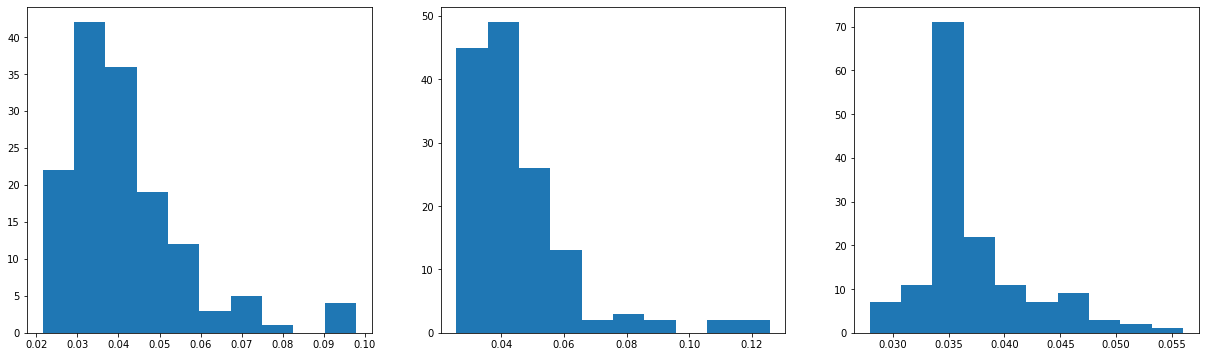

In [10]:
plt.figure(figsize=(21, 6))

plt.subplot(1, 3, 1)
plt.hist(Qcomps.ravel(), bins=10)

plt.subplot(1, 3, 2)
plt.hist(Kcomps.ravel(), bins=10)

plt.subplot(1, 3, 3)
plt.hist(Vcomps.ravel(), bins=10)
plt.show()

In [11]:
Qcomps.mean(), Kcomps.mean(), Vcomps.mean()

(0.041662633, 0.0447317, 0.03715618)

In [12]:
np.max(Kcomps)

0.1256728

### Bias composition terms

In [13]:
b = model.transformer.h[0].attn.attention.out_proj.bias.data.numpy()

In [15]:
b_ = b - b.mean()

bQcomps = np.empty((12,), dtype=np.float32)
bKcomps = np.empty((12,), dtype=np.float32)
bVcomps = np.empty((12,), dtype=np.float32)

for i in range(12):
    bQcomps[i] = comp.Qcomposition(QKs[i], b_, center=False)
    bKcomps[i] = comp.Kcomposition(QKs[i], b_, center=False)
    bVcomps[i] = comp.Vcomposition(QKs[i], b_, center=False)

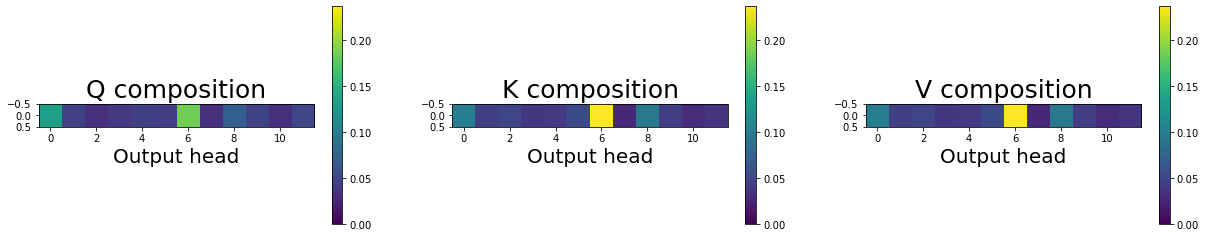

In [16]:
norm = matplotlib.colors.Normalize(
    0,  # min(Qcomps.min(), Kcomps.min(), Vcomps.min()),
    max(bQcomps.max(), bKcomps.max(), bVcomps.max()),
)

plt.figure(figsize=(21, 4))

plt.subplot(1, 3, 1)
plt.title("Q composition", fontsize=25)
plt.imshow(bQcomps.reshape(1, -1), norm=norm)

plt.xlabel("Output head", fontsize=20)
plt.colorbar()


plt.subplot(1, 3, 2)
plt.title("K composition", fontsize=25)
plt.imshow(bKcomps.reshape(1, -1), norm=norm)

plt.xlabel("Output head", fontsize=20)
plt.colorbar()


plt.subplot(1, 3, 3)
plt.title("V composition", fontsize=25)
plt.imshow(bVcomps.reshape(1, -1), norm=norm)

plt.xlabel("Output head", fontsize=20)
plt.colorbar()

plt.show()

In [17]:
Qcomps.mean(), Kcomps.mean(), Vcomps.mean()

(0.041662633, 0.0447317, 0.03715618)

In [18]:
bQcomps.max(), bKcomps.max(), bVcomps.max()

(0.18519224, 0.236695, 0.236695)

$ A^{h_q} X A^{h_k} X (Ws) $

$ A^{h_q} X (A^{h_k}yWs^T) $

$ A^{h_q}x(A^{h_k}yWs^T)^T $

$ A^{h_q}xWsy^T{A^{h_k}}^T $

$ A^{h_q} X A^{h_k} X (Ws) $

$ (A^{h_q}x{A^{h_k}}^T) X (Ws) $

$ A^{h_q}x{A^{h_k}}^TyWs^nT $

In [19]:
model.transformer.h[0].ln_2.bias.data.numpy().shape

(768,)

In [20]:
import pandas as pd

In [21]:
df = pd.read_csv("../test.csv", index_col=0)

In [22]:
df.head()

,src_type,src_layer,src_index,dst_type,dst_layer,dst_index,contrib_type,value
0,att_head,0,0,mlp_weight,0,0,mlp,0.033481
1,att_head,0,0,head,1,0,Q,0.063658
2,att_head,0,0,head,1,0,K,0.061614
3,att_head,0,0,head,1,0,V,0.026479
4,att_head,0,0,head,1,1,Q,0.041288


In [25]:
pd.unique(df.src_type)

array(['att_head', 'att_bias', 'mlp_weight', 'mlp_bias',
       'layernorm_bias1'], dtype=object)

In [26]:
Qcomps[0, 0]

0.06365803

In [27]:
Kcomps[0, 0]

0.061614133